<a href="https://colab.research.google.com/github/Alejandro-ZZ/Machine-Learning-UNS/blob/master/TP_3-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ejercicio 3.3.**

Se desarrolla un **clasificador k vecinos más cercanos (knn)** para predecir si una canción dada va a ser gustada o no. Se implementará un **dataset con más de 2000 canciones de Spotify de un usuario**, donde algunas fueron marcadas como gustadas y otras no.

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

Primero se lee y visualiza el dataset a trabajar

In [ ]:
spotify_data = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv")
spotify_data.head(n=10)

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys
5,5,0.00479,0.804,251333,0.560,0.000000,8,0.1640,-6.682,1,0.1850,85.023,4.0,0.264,1,Sneakin’,Drake
6,6,0.01450,0.739,241400,0.472,0.000007,1,0.2070,-11.204,1,0.1560,80.030,4.0,0.308,1,Childs Play,Drake
7,7,0.02020,0.266,349667,0.348,0.664000,10,0.1600,-11.609,0,0.0371,144.154,4.0,0.393,1,Gyöngyhajú lány,Omega
8,8,0.04810,0.603,202853,0.944,0.000000,11,0.3420,-3.626,0,0.3470,130.035,4.0,0.398,1,I've Seen Footage,Death Grips
9,9,0.00208,0.836,226840,0.603,0.000000,7,0.5710,-7.792,1,0.2370,99.994,4.0,0.386,1,Digital Animal,Honey Claws


Se elimina la columna ***'Unnamed: 0'*** ya que es solo el índice de cada observación. Seguido, se obtienen los atributos (también estandarizados) y la columna objetivo.

In [ ]:
# Se elimina la columna 'Unnamed: 0' que es solo enumeracion de las filas
spotify_data = spotify_data.drop(columns='Unnamed: 0')

#Se codifican algunos atributos a valores numéricos
le = LabelEncoder()
spotify_data['song_title'] = le.fit_transform(spotify_data['song_title'])
spotify_data['artist'] = le.fit_transform(spotify_data['artist'])

# Se extraen los atributos (features) y objetivo (target)
X = spotify_data.drop(columns='target')
y = spotify_data['target']

# Se obtienen los atributos estandarizados
scaler = StandardScaler()
scaler.fit(X)
X_norm = pd.DataFrame(scaler.transform(X), columns=X.columns)

Primero se realiza un análisis paramétrico con todo el dataset y luego se explora el comportamiento del modelo ante la eliminación de algunos atributos que no aportan mayor información

## **Split 1:** 50% Train

A continuación se realiza un análisis del modelo con un 50% de los datos para entrenamiento, tanto para los atributos estandarizados como los que no.

### **Datos sin estandarizar**

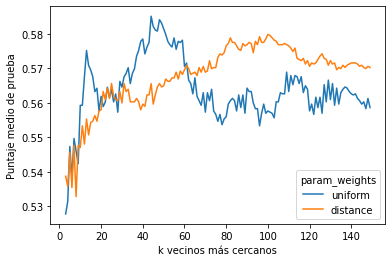

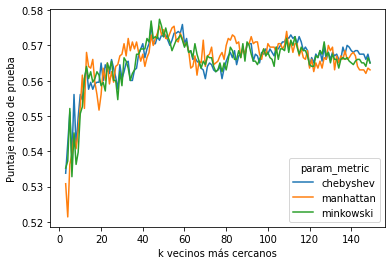

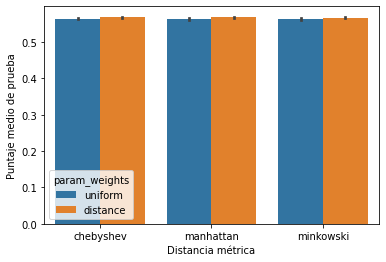


El mejor puntaje es 0.5873602285601695 con metric: minkowski, weight: uniform y k = 44



In [ ]:
# Se divide el dataset para entrenamiento (50% train) y prueba (50% test)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=4)

# Creación del modelo Knn
neigh = KNeighborsClassifier()

# Parametros a evaluar
# Por defecto Knn presenta -> weights: 'uniform' y metric: 'minkowski' (equivalente a 'standard Euclidean')
parameters = {
    'n_neighbors': [n for n in range(3,150)],
    'weights': ['uniform', 'distance'],
    'metric': ['chebyshev', 'manhattan', 'minkowski']
}

# Se implementa un valor de 5-folds (cv=5) usado en la validación cruzada
clf = GridSearchCV(neigh, parameters, cv=5, return_train_score=False)
clf.fit(X_train,y_train)

# Se toman los resultados y se convierten en un DataFrame
results = pd.DataFrame(clf.cv_results_)

# Se extraen los parametros y su respectiva puntuacion media 
grid_summary = results[['param_metric', 'param_n_neighbors', 'param_weights', 'mean_test_score']]

sns.lineplot(x='param_n_neighbors', y='mean_test_score', ci=None, hue='param_weights', data=grid_summary)
plt.xlabel('k vecinos más cercanos')
plt.ylabel('Puntaje medio de prueba')
plt.show()

sns.lineplot(x='param_n_neighbors', y='mean_test_score', ci=None, hue='param_metric', data=grid_summary)
plt.xlabel('k vecinos más cercanos')
plt.ylabel('Puntaje medio de prueba')
plt.show()

sns.barplot(x="param_metric", y="mean_test_score", hue="param_weights", data=grid_summary)
plt.xlabel('Distancia métrica')
plt.ylabel('Puntaje medio de prueba')
plt.show()

print("\nEl mejor puntaje es {} con metric: {}, weight: {} y k = {}\n".format(clf.best_score_, 
                                                                              clf.best_params_['metric'],
                                                                              clf.best_params_['weights'], 
                                                                              clf.best_params_['n_neighbors']))

In [ ]:
# Se escogen los puntajes superiores a 0.57
grid_summary.loc[grid_summary['mean_test_score'] > 0.57].sort_values(by = 'mean_test_score', ascending=False).head(n=10)

,param_metric,param_n_neighbors,param_weights,mean_test_score
670,minkowski,44,uniform,0.587360
680,minkowski,49,uniform,0.585380
82,chebyshev,44,uniform,0.585375
678,minkowski,48,uniform,0.585365
384,manhattan,48,uniform,0.585360
672,minkowski,45,uniform,0.584385
382,manhattan,47,uniform,0.584380
380,manhattan,46,uniform,0.584370
455,manhattan,83,distance,0.583420
74,chebyshev,40,uniform,0.583410


### **Modelo #1.1**

Con la anterior evaluación se genera el modelo con los parámetros que mejor puntaje arrojaron

In [ ]:
# Entrenamiento del modelo y predicción
neigh = KNeighborsClassifier(n_neighbors = 44, weights = 'uniform', metric = 'minkowski').fit(X_train,y_train)
y_pred = neigh.predict(X_test)

# Evaluación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62       490
           1       0.63      0.52      0.57       519

    accuracy                           0.59      1009
   macro avg       0.60      0.59      0.59      1009
weighted avg       0.60      0.59      0.59      1009



En este primer Split, con todos los atributos y sin estandarizar, se obtiene una **exactitud del 59%**.

### **Datos estandarizados**

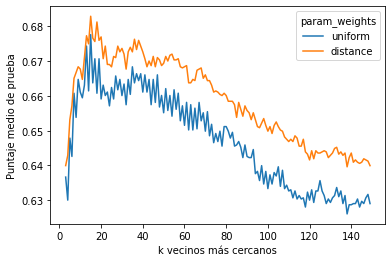

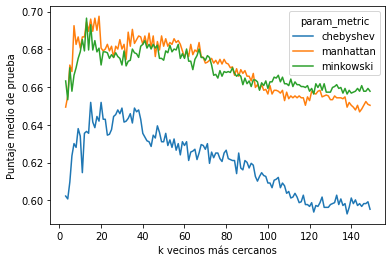

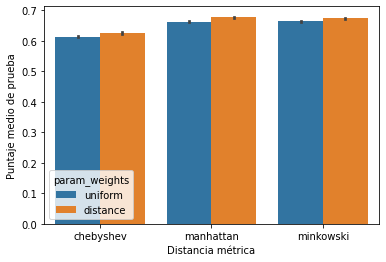


El mejor puntaje es 0.7034382542731885 con metric: manhattan, weight: distance y k = 18



In [ ]:
# Se divide el dataset para entrenamiento (50% train) y prueba (50% test)
X_train, X_test, y_train, y_test = train_test_split( X_norm, y, test_size=0.5, random_state=4)

# Creación del modelo Knn
neigh = KNeighborsClassifier()

# Parametros a evaluar
# Por defecto Knn presenta -> weights: 'uniform' y metric: 'minkowski' (equivalente a 'standard Euclidean')
parameters = {
    'n_neighbors': [n for n in range(3,150)],
    'weights': ['uniform', 'distance'],
    'metric': ['chebyshev', 'manhattan', 'minkowski']
}

# Se implementa un valor de 5-folds (cv=5) usado en la validación cruzada
clf = GridSearchCV(neigh, parameters, cv=5, return_train_score=False)
clf.fit(X_train,y_train)

# Se toman los resultados y se convierten en un DataFrame
results = pd.DataFrame(clf.cv_results_)

# Se extraen los parametros y su respectiva puntuacion media 
grid_summary = results[['param_metric', 'param_n_neighbors', 'param_weights', 'mean_test_score']]

sns.lineplot(x='param_n_neighbors', y='mean_test_score', ci=None, hue='param_weights', data=grid_summary)
plt.xlabel('k vecinos más cercanos')
plt.ylabel('Puntaje medio de prueba')
plt.show()

sns.lineplot(x='param_n_neighbors', y='mean_test_score', ci=None, hue='param_metric', data=grid_summary)
plt.xlabel('k vecinos más cercanos')
plt.ylabel('Puntaje medio de prueba')
plt.show()

sns.barplot(x="param_metric", y="mean_test_score", hue="param_weights", data=grid_summary)
plt.xlabel('Distancia métrica')
plt.ylabel('Puntaje medio de prueba')
plt.show()

print("\nEl mejor puntaje es {} con metric: {}, weight: {} y k = {}\n".format(clf.best_score_, 
                                                                              clf.best_params_['metric'],
                                                                              clf.best_params_['weights'], 
                                                                              clf.best_params_['n_neighbors']))

In [ ]:
# Se escogen los puntajes superiores a 0.57
grid_summary.loc[grid_summary['mean_test_score'] > 0.57].sort_values(by = 'mean_test_score', ascending=False).head(n=10)

,param_metric,param_n_neighbors,param_weights,mean_test_score
325,manhattan,18,distance,0.703438
321,manhattan,16,distance,0.703409
327,manhattan,19,distance,0.700473
323,manhattan,17,distance,0.700453
317,manhattan,14,distance,0.700433
319,manhattan,15,distance,0.698468
609,minkowski,13,distance,0.697488
315,manhattan,13,distance,0.696512
608,minkowski,13,uniform,0.695498
365,manhattan,38,distance,0.695483


### **Modelo #1.2**

In [ ]:
# Entrenamiento del modelo y predicción
neigh = KNeighborsClassifier(n_neighbors = 18, weights = 'distance', metric = 'manhattan').fit(X_train,y_train)
y_pred = neigh.predict(X_test)

# Evaluación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.87      0.74       490
           1       0.82      0.55      0.66       519

    accuracy                           0.71      1009
   macro avg       0.73      0.71      0.70      1009
weighted avg       0.73      0.71      0.70      1009



- Para este primer análisis se observa que se obtienen **mejores puntajes para los datos estandarizados** (un 71% en comparación de un 59%).

- En la evaluación con los atributos estandarizados, se observa que el parámetro **metric: chebyshev** presenta un **puntaje notablemente inferior** respecto a manhattan y  minkowski.

- Para el parámetro **weight = uniform** el modelo presenta un comportamiento inferior respecto a distance.

## **Split 2:** 70% Train

Ahora se evalua el comportamiento para un 70% de los datos como entrenamiento

### **Datos sin estandarizar**

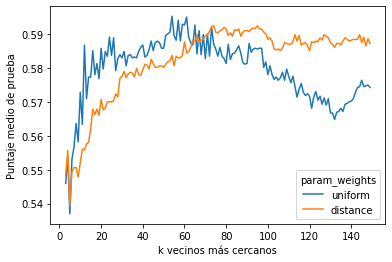

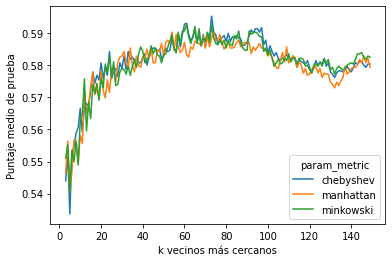

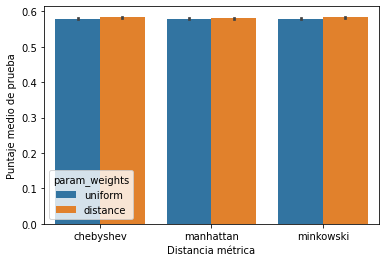


El mejor puntaje es 0.6002681502643912 con metric: chebyshev, weight: uniform y k = 61



In [ ]:
# Se divide el dataset para entrenamiento (70% train) y prueba (30% test)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)

# Creación del modelo Knn
neigh = KNeighborsClassifier()

# Parametros a evaluar
# Por defecto Knn presenta -> weights: 'uniform' y metric: 'minkowski' (equivalente a 'standard Euclidean')
parameters = {
    'n_neighbors': [n for n in range(3,150)],
    'weights': ['uniform', 'distance'],
    'metric': ['chebyshev', 'manhattan', 'minkowski']
}

# Se implementa un valor de 5-folds (cv=5) usado en la validación cruzada
clf = GridSearchCV(neigh, parameters, cv=5, return_train_score=False)
clf.fit(X_train,y_train)

# Se toman los resultados y se convierten en un DataFrame
results = pd.DataFrame(clf.cv_results_)

# Se extraen los parametros y su respectiva puntuacion media 
grid_summary = results[['param_metric', 'param_n_neighbors', 'param_weights', 'mean_test_score']]

sns.lineplot(x='param_n_neighbors', y='mean_test_score', ci=None, hue='param_weights', data=grid_summary)
plt.xlabel('k vecinos más cercanos')
plt.ylabel('Puntaje medio de prueba')
plt.show()

sns.lineplot(x='param_n_neighbors', y='mean_test_score', ci=None, hue='param_metric', data=grid_summary)
plt.xlabel('k vecinos más cercanos')
plt.ylabel('Puntaje medio de prueba')
plt.show()

sns.barplot(x="param_metric", y="mean_test_score", hue="param_weights", data=grid_summary)
plt.xlabel('Distancia métrica')
plt.ylabel('Puntaje medio de prueba')
plt.show()

print("\nEl mejor puntaje es {} con metric: {}, weight: {} y k = {}\n".format(clf.best_score_, 
                                                                              clf.best_params_['metric'],
                                                                              clf.best_params_['weights'], 
                                                                              clf.best_params_['n_neighbors']))

### **Modelo #2.1**

In [ ]:
# Entrenamiento del modelo y predicción
neigh = KNeighborsClassifier(n_neighbors = 61, weights = 'uniform', metric = 'chebyshev').fit(X_train,y_train)
y_pred = neigh.predict(X_test)

# Evaluación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.58      0.56       291
           1       0.58      0.54      0.56       315

    accuracy                           0.56       606
   macro avg       0.56      0.56      0.56       606
weighted avg       0.56      0.56      0.56       606



La exactitud en este caso es de 56%, inferior con respecto al modelo 1.1 donde se obtuvo un 59%

### **Datos estandarizados**

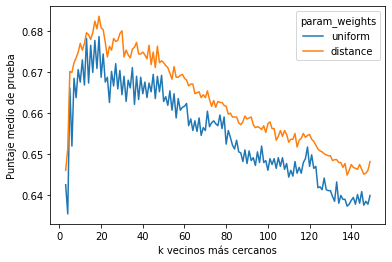

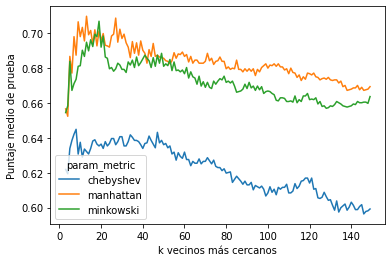

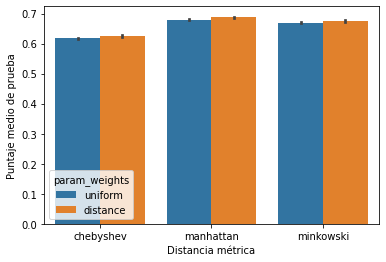


El mejor puntaje es 0.7122647419993485 con metric: manhattan, weight: distance y k = 13



In [ ]:
# Se divide el dataset para entrenamiento (70% train) y prueba (30% test)
X_train, X_test, y_train, y_test = train_test_split( X_norm, y, test_size=0.3, random_state=4)

# Creación del modelo Knn
neigh = KNeighborsClassifier()

# Parametros a evaluar
# Por defecto Knn presenta -> weights: 'uniform' y metric: 'minkowski' (equivalente a 'standard Euclidean')
parameters = {
    'n_neighbors': [n for n in range(3,150)],
    'weights': ['uniform', 'distance'],
    'metric': ['chebyshev', 'manhattan', 'minkowski']
}

# Se implementa un valor de 5-folds (cv=5) usado en la validación cruzada
clf = GridSearchCV(neigh, parameters, cv=5, return_train_score=False)
clf.fit(X_train,y_train)

# Se toman los resultados y se convierten en un DataFrame
results = pd.DataFrame(clf.cv_results_)

# Se extraen los parametros y su respectiva puntuacion media 
grid_summary = results[['param_metric', 'param_n_neighbors', 'param_weights', 'mean_test_score']]

sns.lineplot(x='param_n_neighbors', y='mean_test_score', ci=None, hue='param_weights', data=grid_summary)
plt.xlabel('k vecinos más cercanos')
plt.ylabel('Puntaje medio de prueba')
plt.show()

sns.lineplot(x='param_n_neighbors', y='mean_test_score', ci=None, hue='param_metric', data=grid_summary)
plt.xlabel('k vecinos más cercanos')
plt.ylabel('Puntaje medio de prueba')
plt.show()

sns.barplot(x="param_metric", y="mean_test_score", hue="param_weights", data=grid_summary)
plt.xlabel('Distancia métrica')
plt.ylabel('Puntaje medio de prueba')
plt.show()

print("\nEl mejor puntaje es {} con metric: {}, weight: {} y k = {}\n".format(clf.best_score_, 
                                                                              clf.best_params_['metric'],
                                                                              clf.best_params_['weights'], 
                                                                              clf.best_params_['n_neighbors']))

### **Modelo #2.2**

In [ ]:
# Entrenamiento del modelo y predicción
neigh = KNeighborsClassifier(n_neighbors = 13, weights = 'distance', metric = 'manhattan').fit(X_train,y_train)
y_pred = neigh.predict(X_test)

# Evaluación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.86      0.74       291
           1       0.81      0.57      0.67       315

    accuracy                           0.71       606
   macro avg       0.73      0.72      0.71       606
weighted avg       0.74      0.71      0.70       606



- Nuevamente, se obtienen **mejores resultados para los atributos estandarizados**. Sin embargo, respecto al *Split 1*, se denota un pequeño incremento en la evaluación del modelo 2.2.

- Si bien se obtienen mejores puntajes en los datos no estandarizados, respecto al *split 1*, al evaluar la mejor combinación con el segmento de *Test*, arroja una evaluación inferior.

- De nuevo, para los datos estandarizados, el parámetro metric: chebyshev, presenta un puntaje inferior respecto a los otros dos evaluados.

## **Selección de atributos**

Una vez conocido el comportamiento del modelo manteniendo todos los atributos, se realizará un análisis para conocer cual de los incluidos pueden ser omitidos y posterior a ello se vuelve a evaluar el modelo y su resultado.

### **Correlación**

Se procede a conocer la correlación entre los atributos. El objetivo es conocer aquellos que aporten menor información respecto a la columna objetivo y los que tengan un comportamiento similar entre sí

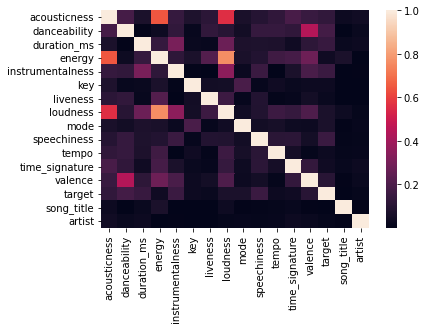

In [ ]:
sns.heatmap(spotify_data.corr().abs())
plt.show()

En general los atributos del dataset presentan una correlación baja. Los únicos que presenta un valor relativamente alto son ***energy*** y ***loudness*** con un valor aproximado de 0.7.
<br><br>
Veamos ahora la correlación de los atributos con la columna del objetivo

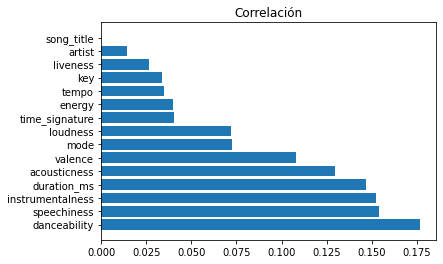

In [ ]:
target_corr = spotify_data.corr().abs()['target'].drop(labels='target').sort_values(ascending=False)
plt.barh(width=target_corr.values, y=target_corr.index)
plt.title("Correlación")
plt.show()

In [ ]:
feat_var = X.var().sort_values(ascending=False)
feat_var

duration_ms         6.721018e+09
song_title          3.180996e+05
artist              1.512176e+05
tempo               7.121214e+02
loudness            1.415027e+01
key                 1.330966e+01
mode                2.375075e-01
instrumentalness    7.461758e-02
acousticness        6.759442e-02
time_signature      6.546094e-02
valence             6.110560e-02
energy              4.421474e-02
danceability        2.593033e-02
liveness            2.416569e-02
speechiness         8.087668e-03
dtype: float64

- Se observa que las variables como ***song_title***, ***artist***, ***liveness*** y ***key*** son los atributos que menor correlación presentan con la columna a predecir. Esto podría ser un indicio a los posibles columnas a eliminar ya que, presuntamente, no aportarían mayor información. 

- Tambien se observa que ***speechiness*** es la columna con menor varianza de todas. Esto podría indicar que no genera mayor importancia para le modelo, ya que varía muy poco.

Sin embargo, ahora se realiza un análisis a partir de otros modelos.

### **Arbol de desición**

Ahora se evaluaran los atributos a partir de un arbol de desición para conocer el nivel de importancia.

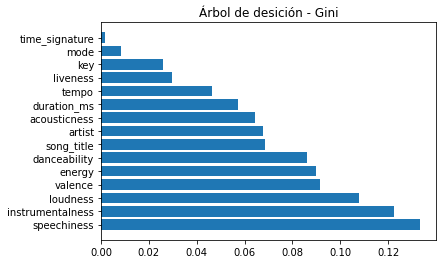

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dummy_tree = DecisionTreeClassifier(criterion="gini")
dummy_tree.fit(X,y)

importance = dummy_tree.feature_importances_

feats = {}

for feature, imp in zip(X_norm.columns, importance):
  feats[feature] = imp

feats_serie = pd.Series(feats).sort_values(ascending=False)

plt.barh(width=feats_serie.values, y=feats_serie.index)
plt.title("Árbol de desición - Gini")
plt.show()

Para este caso, las cinco (5) columnas con mayor importancia son:

1. speechiness
2. instrumentalness
3. loudness
4. valence
5. energy

Ejecutando el mismo procedimiento pero cambiando el parámetro ***criterion*** a ***entropy***, se obteine lo siguiente:

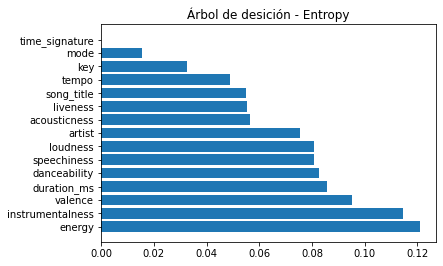

In [ ]:
dummy_tree = DecisionTreeClassifier(criterion="entropy")
dummy_tree.fit(X,y)

importance = dummy_tree.feature_importances_

feats = {}

for feature, imp in zip(X_norm.columns, importance):
  feats[feature] = imp

feats_serie = pd.Series(feats).sort_values(ascending=False)

plt.barh(width=feats_serie.values, y=feats_serie.index)
plt.title("Árbol de desición - Entropy")
plt.show()

Variables más importantes:

1. energy
2. instrumentalness
3. valence
4. duration_ms
5. danceability

### **LassoCV**

Ahora se implementa un análisis a partir del estimador LassoCV

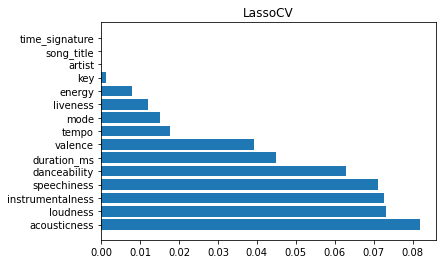

In [ ]:
from sklearn.linear_model import LassoCV

lasso = LassoCV().fit(X_norm, y)
importance = np.abs(lasso.coef_)
feature_names = np.array(X_norm.columns)

feats = {}

for feature, imp in zip(X_norm.columns, importance):
  feats[feature] = imp

feats_serie = pd.Series(feats).sort_values(ascending=False)

plt.barh(width=feats_serie.values, y=feats_serie.index)
plt.title("LassoCV")
plt.show()

Como resultado se obtienen las siguientes variables más importantes:

1. acousticness
2. loudness
3. instrumentalness
4. speechiness
5. danceability



### **Filtro de atributos**

A partir del anterior análisis, se omiten algunos atributos y se observa si este cambio afecta en pro el comportamiento del modelo. Se omiten los siguientes atributos:

- key
- mode
- time_signature
- song_title
- artist
- liveness
- tempo

In [ ]:
X_new = X_norm[['energy', 'instrumentalness', 'valence', 'danceability', 'loudness', 'speechiness', 
                'duration_ms', 'acousticness']]
X_new.head()

,energy,instrumentalness,valence,danceability,loudness,speechiness,duration_ms,acousticness
0,-1.177700,-0.407864,-0.853039,1.332874,-0.454530,3.763084,-0.508851,-0.682467
1,-1.534468,-0.465683,0.368970,0.773830,-0.881573,-0.147529,0.983716,0.043897
2,-1.282352,-0.487200,-1.310280,1.363932,-0.016586,2.183712,-0.739362,-0.589363
3,-1.634363,1.379429,-1.079636,-0.772860,-2.167220,-0.740350,-0.572137,1.602040
4,-0.573574,1.386753,1.647627,0.370075,-1.213155,-0.258753,1.788484,-0.029201


## **Evaluacion final**

Se conoce el comportamiento del modelo con los nuevos atributos. Esta vez, se trabaja de la siguiente manera:

- Se particionan los datos como en el caso del split 2 (70% Train) ya que arrojó un leve mejor comportamiento respecto al split 1

- Se implementa solo los datos estandarizados, ya que fueron los que mejor resultado arrojaron 

- Se trabajan valores de k vecinos más cercanos inferiores a 60 (k < 60) ya que, como se observó en las evaluaciones previas, por encima de 60 los puntajes empiezan a disminuir.

- Se omite el parametro de *chebyshev* al presentar un comportamiento inferior notable en los modelos 1.2 y 2.2

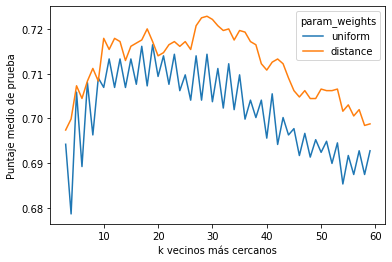

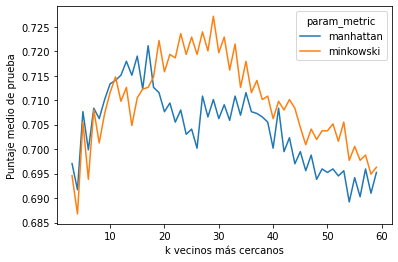


El mejor puntaje es 0.7306768914617947 con metric: minkowski, weight: distance y k = 29



In [ ]:
# Se divide el dataset para entrenamiento (70% train) y prueba (30% test)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=4)

# Creación del modelo Knn
neigh = KNeighborsClassifier()

# Parametros a evaluar
# Por defecto Knn presenta -> weights: 'uniform' y metric: 'minkowski' (equivalente a 'standard Euclidean')
parameters = {
    'n_neighbors': [n for n in range(3,60)],
    'weights': ['uniform', 'distance'],
    'metric': ['manhattan', 'minkowski']
}

# Se implementa un valor de 5-folds (cv=5) usado en la validación cruzada
clf = GridSearchCV(neigh, parameters, cv=5, return_train_score=False)
clf.fit(X_train,y_train)

# Se toman los resultados y se convierten en un DataFrame
results = pd.DataFrame(clf.cv_results_)

# Se extraen los parametros y su respectiva puntuacion media 
grid_summary = results[['param_metric', 'param_n_neighbors', 'param_weights', 'mean_test_score']]

sns.lineplot(x='param_n_neighbors', y='mean_test_score', ci=None, hue='param_weights', data=grid_summary)
plt.xlabel('k vecinos más cercanos')
plt.ylabel('Puntaje medio de prueba')
plt.show()

sns.lineplot(x='param_n_neighbors', y='mean_test_score', ci=None, hue='param_metric', data=grid_summary)
plt.xlabel('k vecinos más cercanos')
plt.ylabel('Puntaje medio de prueba')
plt.show()

print("\nEl mejor puntaje es {} con metric: {}, weight: {} y k = {}\n".format(clf.best_score_, 
                                                                              clf.best_params_['metric'],
                                                                              clf.best_params_['weights'], 
                                                                              clf.best_params_['n_neighbors']))

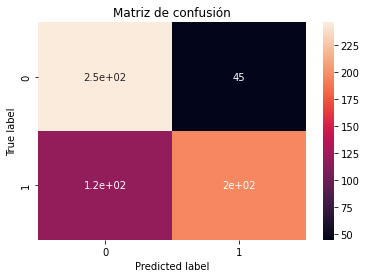

              precision    recall  f1-score   support

           0       0.67      0.85      0.75       291
           1       0.81      0.62      0.71       315

    accuracy                           0.73       606
   macro avg       0.74      0.73      0.73       606
weighted avg       0.75      0.73      0.73       606



In [ ]:
# Entrenamiento del modelo y predicción
neigh = KNeighborsClassifier(n_neighbors = 20, weights = 'distance', metric = 'minkowski').fit(X_train,y_train)
y_pred = neigh.predict(X_test)

# Matriz de confusión
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['True label'], colnames=['Predicted label'])

sns.heatmap(confusion_matrix, annot=True)
plt.title("Matriz de confusión")
plt.show()

# Evaluación
print(classification_report(y_test, y_pred))

Como se observa, a comparación del modelo 2.2, se obtiene un comportamiento levemente mejor con una exactitud del 73% respecto a un 71%.

## **Conclusión**

- El modelo final arroja una **exactitud y F1-Score del 73%** (con un 70% Train y 30% Test).

- El modelo presentó levemente un **mejor comprtamiento utilizando el 70% de los datos para entrenamiento** que al dividir en un 50%.

- Durante toda la práctica se implementa un análisis exploratorio por medio de GridSearchCV para encontrar la mejor combinación de parámetros del modelo. Se encuentra que para **k > 60 el puntaje del modelo tiende a disminuir**. Para los datos estandarizados, el parámetro metric: **chebyshev arroja un comportamiento inferior** a comparación de los otros dos evaluados.

- Se implementaron prácticas generales para evaluar la importancia de los atributos. Como resultado de los quince (15) iniciales, **se escogen solo ocho (8)  atributos oteniendo una evaluación superior** respecto al puntaje, usando todas las columnas.

- Otra manera de evaluar el comportamiento del modelo ante la adición o eliminación de atributos es con la libreria [Secuencial Feature Selector](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/#sequentialfeatureselector) de Mlxtend o a partir de los ejemplos mostrados en [Feature Selection | Sklearn](https://scikit-learn.org/stable/modules/feature_selection.html)

- Se contrastó el comportamiento tanto para los datos sin procesar como para los estandarizados. En este caso se elige trabajar con los segundos ya que errojaron mejores comportamientos para el modelo.
